<a href="https://colab.research.google.com/github/Tony-Y/colab-notebooks/blob/master/PyTorch_Warmup_Approach2_chaining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/Tony-Y/pytorch_warmup/master/examples/emnist/download.py

--2024-04-29 08:42:17--  https://raw.githubusercontent.com/Tony-Y/pytorch_warmup/master/examples/emnist/download.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 565 [text/plain]
Saving to: ‘download.py’

download.py         100%[===================>]     565  --.-KB/s    in 0s      

2024-04-29 08:42:17 (28.3 MB/s) - ‘download.py’ saved [565/565]



In [2]:
!python download.py

100% 561753746/561753746 [00:41<00:00, 13659449.45it/s]


In [3]:
!pip install pytorch_warmup

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import pytorch_warmup as warmup
import os
from progressbar import progressbar

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 47)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [6]:
def train(model, device, train_loader, optimizer, lr_scheduler,
          warmup_scheduler, epoch, history):
    model.train()
    for batch_idx, (data, target) in enumerate(progressbar(train_loader)):
        lr = optimizer.param_groups[0]['lr']
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if (batch_idx+1) % log_interval == 0:
            loss = loss.item()
            step = warmup_scheduler.last_step
            history.write(f'{epoch},{step},{loss},{lr}\n')
        if batch_idx < len(train_loader)-1:
            with warmup_scheduler.dampening():
                pass
    with warmup_scheduler.dampening():
        lr_scheduler.step()

In [7]:
def test(model, device, test_loader, epoch, evaluation):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in progressbar(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_acc))
    evaluation.write(f'{epoch},{test_loss},{test_acc}\n')
    evaluation.flush()

In [8]:
torch.manual_seed(12345)
device = torch.device("cuda")

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
        datasets.EMNIST('.data', 'balanced', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1751,), (0.3332,))
                        ])),
        batch_size=64, shuffle=True, drop_last=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
        datasets.EMNIST('.data', 'balanced', train=False,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1751,), (0.3332,))
                        ])),
        batch_size=1000, shuffle=False, **kwargs)

Using downloaded and verified file: .data/EMNIST/raw/gzip.zip
Extracting .data/EMNIST/raw/gzip.zip to .data/EMNIST/raw


In [9]:
warmup_type = "radam"  # choices=['linear', 'exponential', 'radam', 'none']
beta2 = 0.999
wd = 0.01
lr = 0.01
epochs = 10
milestones = [3, 7]
gamma = 0.1
log_interval = 10

In [10]:
output_dir = warmup_type
os.makedirs(output_dir, exist_ok=True)

history = open(os.path.join(output_dir, 'history.csv'), 'w')
history.write('epoch,step,loss,lr\n')

evaluation = open(os.path.join(output_dir, 'evaluation.csv'), 'w')
evaluation.write('epoch,loss,accuracy\n')

model = Net().to(device)

optimizer = optim.AdamW(model.parameters(), lr=lr,
                            betas=(0.9, beta2),
                            weight_decay=wd)
lr_scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer, milestones, gamma)
if warmup_type == 'linear':
        warmup_scheduler = warmup.UntunedLinearWarmup(optimizer)
elif warmup_type == 'exponential':
        warmup_scheduler = warmup.UntunedExponentialWarmup(optimizer)
elif warmup_type == 'radam':
        warmup_scheduler = warmup.RAdamWarmup(optimizer)
elif warmup_type == 'none':
        warmup_scheduler = warmup.LinearWarmup(optimizer, 1)

for epoch in range(1, epochs + 1):
        print(f"Epoch: {epoch} of {epochs}")
        train(model, device, train_loader, optimizer, lr_scheduler,
              warmup_scheduler, epoch, history)
        test(model, device, test_loader, epoch, evaluation)

history.close()
evaluation.close()

Epoch: 1 of 10


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100% (1762 of 1762) |####################| Elapsed Time: 0:00:37 Time:  0:00:37
100% (19 of 19) |########################| Elapsed Time: 0:00:04 Time:  0:00:04



Test set: Average loss: 0.5140, Accuracy: 15620/18800 (83.09%)

Epoch: 2 of 10


100% (1762 of 1762) |####################| Elapsed Time: 0:00:35 Time:  0:00:35
100% (19 of 19) |########################| Elapsed Time: 0:00:04 Time:  0:00:04



Test set: Average loss: 0.5643, Accuracy: 15251/18800 (81.12%)

Epoch: 3 of 10


100% (1762 of 1762) |####################| Elapsed Time: 0:00:36 Time:  0:00:36
100% (19 of 19) |########################| Elapsed Time: 0:00:03 Time:  0:00:03



Test set: Average loss: 0.5562, Accuracy: 15376/18800 (81.79%)

Epoch: 4 of 10


100% (1762 of 1762) |####################| Elapsed Time: 0:00:36 Time:  0:00:36
100% (19 of 19) |########################| Elapsed Time: 0:00:03 Time:  0:00:03



Test set: Average loss: 0.3901, Accuracy: 16278/18800 (86.59%)

Epoch: 5 of 10


100% (1762 of 1762) |####################| Elapsed Time: 0:00:36 Time:  0:00:36
100% (19 of 19) |########################| Elapsed Time: 0:00:04 Time:  0:00:04



Test set: Average loss: 0.3812, Accuracy: 16398/18800 (87.22%)

Epoch: 6 of 10


100% (1762 of 1762) |####################| Elapsed Time: 0:00:36 Time:  0:00:36
100% (19 of 19) |########################| Elapsed Time: 0:00:03 Time:  0:00:03



Test set: Average loss: 0.3808, Accuracy: 16458/18800 (87.54%)

Epoch: 7 of 10


100% (1762 of 1762) |####################| Elapsed Time: 0:00:35 Time:  0:00:35
100% (19 of 19) |########################| Elapsed Time: 0:00:03 Time:  0:00:03



Test set: Average loss: 0.3980, Accuracy: 16464/18800 (87.57%)

Epoch: 8 of 10


100% (1762 of 1762) |####################| Elapsed Time: 0:00:36 Time:  0:00:36
100% (19 of 19) |########################| Elapsed Time: 0:00:04 Time:  0:00:04



Test set: Average loss: 0.4027, Accuracy: 16475/18800 (87.63%)

Epoch: 9 of 10


100% (1762 of 1762) |####################| Elapsed Time: 0:00:36 Time:  0:00:36
100% (19 of 19) |########################| Elapsed Time: 0:00:04 Time:  0:00:04



Test set: Average loss: 0.4099, Accuracy: 16507/18800 (87.80%)

Epoch: 10 of 10


100% (1762 of 1762) |####################| Elapsed Time: 0:00:36 Time:  0:00:36
100% (19 of 19) |########################| Elapsed Time: 0:00:03 Time:  0:00:03



Test set: Average loss: 0.4186, Accuracy: 16491/18800 (87.72%)



In [11]:
import pandas as pd

df_hist = pd.read_csv(os.path.join(warmup_type, "history.csv"))
df_eval = pd.read_csv(os.path.join(warmup_type, "evaluation.csv"))

<Axes: xlabel='step'>

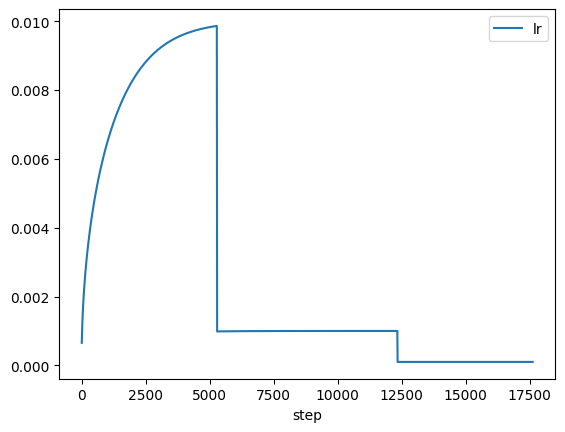

In [12]:
df_hist.plot(x="step", y="lr")

<Axes: xlabel='step'>

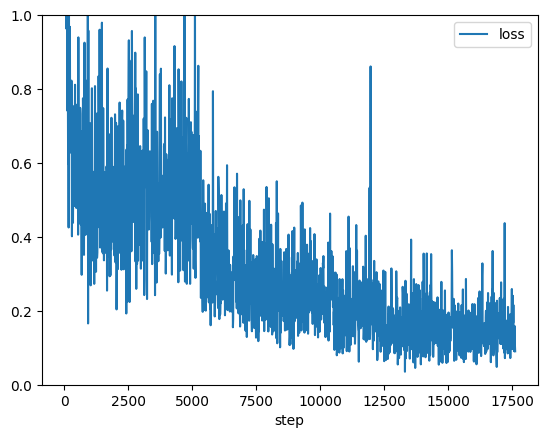

In [13]:
df_hist.plot(x="step", y="loss", ylim=(0,1))

<Axes: xlabel='epoch'>

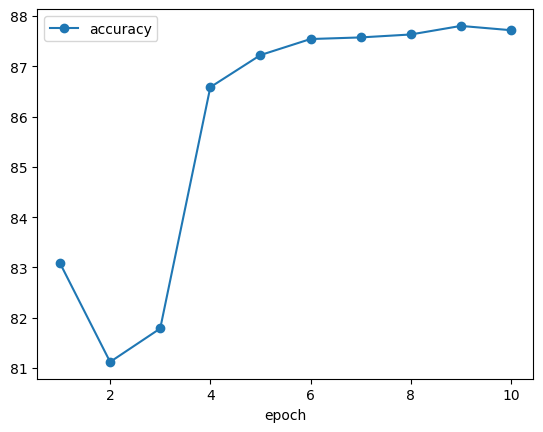

In [14]:
df_eval.plot(x="epoch", y="accuracy", marker="o")